In [1]:
import pandas as pd
import numpy as np
import ast

# 单步法按batch合并数据

In [8]:
data = pd.read_excel('data_stage3/one_step_attack_total1000_1016/one_step_attack_total1000_1016.xlsx')
print(data.shape)
data.head()

(100, 16)


model  algo mask_mode  parameter   eta  pixel_attacked  \
0  vit_b_16  fgsm      topr       0.01  0.01            1505   
1  vit_b_16  fgsm      topr       0.11  0.01           16558   
2  vit_b_16  fgsm      topr       0.21  0.01           31610   
3  vit_b_16  fgsm      topr       0.31  0.01           46663   
4  vit_b_16  fgsm      topr       0.41  0.01           61716   

   attack_ratio_per_channel  l1_norm   l2_norm  success_rate  original_loss  \
0  [0.0094, 0.0137, 0.0069]   8.8347  0.002750          0.04          0.142   
1  [0.1056, 0.1381, 0.0863]  31.2452  0.004299          0.18          0.142   
2   [0.204, 0.2524, 0.1736]  41.2271  0.004582          0.26          0.142   
3  [0.3039, 0.3604, 0.2658]  47.6534  0.004699          0.31          0.142   
4  [0.4043, 0.4638, 0.3618]  52.1607  0.004757          0.33          0.142   

   attack_loss  pred_loss  run_time  batch_idx  batch_pictures  
0        0.201   0.230347     1.510          1             100  
1        0.517   0.454452     1.222          1             100  
2        0.744   0.554271     1.254          1             100  
3        0.914   0.618534     1.251          1             100  
4        1.047   0.663607     1.269          1             100

In [9]:
def mean_of_lists(series):
    # 将每个元素转换为 NumPy 数组，然后计算均值
    arrays = np.array(series.tolist(), dtype=float)
    return np.mean(arrays, axis=0).tolist()

def calculate_eta_reverse(row):
    if row['mask_mode'] in ('cam_lowr', 'lowr', 'seed_randomr_lowr'):
        return 1 - row['parameter']
    else:
        return row['parameter']

def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    data['attack_ratio_per_channel'] = data['attack_ratio_per_channel'].apply(ast.literal_eval)
    li = ['model', 'algo', 'mask_mode', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'pixel_attacked': lambda x: int(x.mean()),
        'attack_ratio_per_channel': mean_of_lists,
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'original_loss'	: 'mean',
        'attack_loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
        'batch_pictures': 'sum', 
    }).reset_index()
    data_grouped[['R', 'G', 'B']] = pd.DataFrame(data_grouped['attack_ratio_per_channel'].tolist(), index=data_grouped.index)
    data_grouped['parameter0'] = data_grouped.apply(calculate_eta_reverse, axis=1)
    data_grouped.drop('attack_ratio_per_channel', axis=1, inplace=True)
    return data_grouped

In [10]:
data_grouped = merge_batch_onestep(data)
print(data_grouped.shape)

(10, 18)


In [11]:
data_grouped.head()

model  algo mask_mode  parameter   eta  pixel_attacked   l1_norm  \
0  vit_b_16  fgsm      topr       0.01  0.01            1505  160.1532   
1  vit_b_16  fgsm      topr       0.11  0.01           16558  458.0008   
2  vit_b_16  fgsm      topr       0.21  0.01           31610  586.1897   
3  vit_b_16  fgsm      topr       0.31  0.01           46663  668.4733   
4  vit_b_16  fgsm      topr       0.41  0.01           61716  726.1401   

    l2_norm  original_loss  attack_loss  pred_loss  success_rate  run_time  \
0  0.459031         0.1441       0.2255   0.304253         0.034    12.056   
1  0.477009         0.1441       0.6464   0.602101         0.206    11.901   
2  0.478792         0.1441       0.9437   0.730290         0.295    12.183   
3  0.479478         0.1441       1.1568   0.812573         0.341    12.281   
4  0.479807         0.1441       1.3139   0.870240         0.377    12.460   

   batch_pictures        R        G        B  parameter0  
0            1000  0.00928  0.01377  0.00695        0.01  
1            1000  0.10554  0.13834  0.08610        0.11  
2            1000  0.20426  0.25277  0.17295        0.21  
3            1000  0.30416  0.36112  0.26471        0.31  
4            1000  0.40471  0.46458  0.36069        0.41

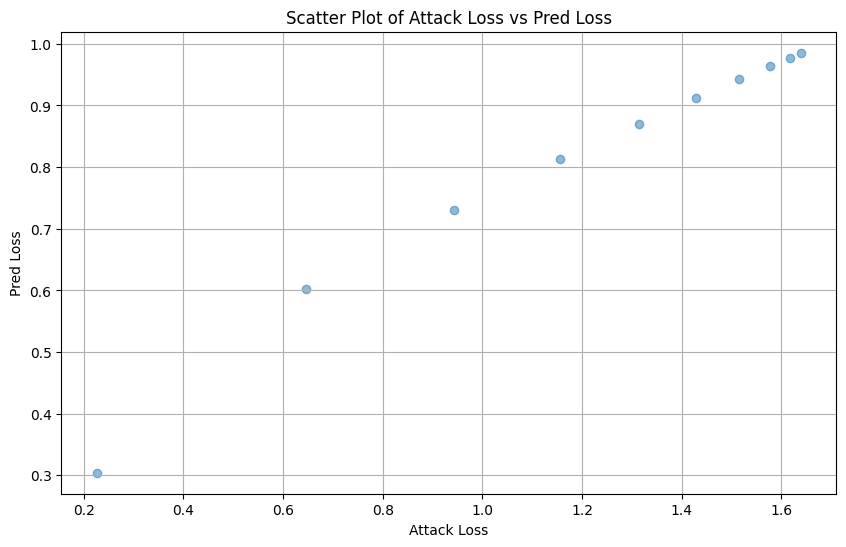

In [12]:
import matplotlib.pyplot as plt

# 假设你的 DataFrame 名为 data_grouped
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(data_grouped['attack_loss'], data_grouped['pred_loss'], alpha=0.5)
plt.title('Scatter Plot of Attack Loss vs Pred Loss')
plt.xlabel('Attack Loss')
plt.ylabel('Pred Loss')
plt.grid(True)
plt.show()

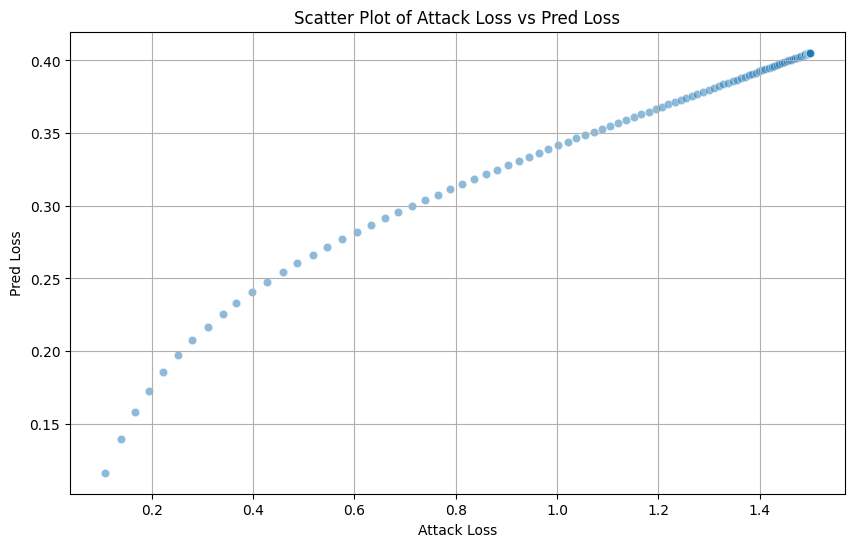

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='attack_loss', y='pred_loss', data=data_grouped, alpha=0.5)
plt.title('Scatter Plot of Attack Loss vs Pred Loss')
plt.xlabel('Attack Loss')
plt.ylabel('Pred Loss')
plt.grid(True)
plt.show()

In [18]:
data_all.to_excel('./data_stage3/one_step_attack_total1000_1012/one_step_attack_total1000_1012_grouped.xlsx', index=False)

# 结果分析

In [3]:
data_grouped = pd.read_excel('data_stage3/one_step_attack_total1000_1012/one_step_attack_total1000_1012_grouped.xlsx')

In [4]:
data_grouped.shape

(36000, 17)

In [6]:
data_root = './data_stage3/single_step_attack_1016'

In [22]:
for column in data_grouped.columns:
    if column not in ('l1_norm', 'l2_norm', 'success_rate','pixel_attacked', 'run_time',  'R', 'G', 'B'):
        unique_values = data_grouped[column].unique()
        print(f"字段 '{column}' 的唯一值: {unique_values}")
print(data_grouped.columns)


字段 'model' 的唯一值: ['resnet50' 'vgg16' 'vit_b_16']
字段 'algo' 的唯一值: ['fgsm' 'gaussian_noise']
字段 'mask_mode' 的唯一值: ['all' 'cam_lowr' 'cam_topr' 'lowr' 'negative' 'positive' 'topr'
 'seed_randomr' 'seed_randomr_lowr']
字段 'parameter' 的唯一值: [-1.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59
  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71
  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83
  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95
  0.96  0.97  0.98  0.99]
字段 'eta' 的唯一值: [0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
字段 'original_loss'

# 画图分析

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import math
from sklearn.linear_model import LinearRegression

In [8]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print("Available fonts:", font_list)

# 使用第一个找到的中文字体
font_path = next((f for f in font_list if 'SimHei' in f or 'SimSun' in f or 'wqy' in f), None)

Available fonts: ['/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf', '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc', '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf']


In [9]:
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'  # 显示中文字体

if not os.path.exists(font_path):
    print(f"字体文件 {font_path} 未找到。请确保字体文件存在于工作目录中。")
else:
    # 创建FontProperties对象
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()


## 1. success_rate vs model&algo
- 只考虑mask_mode in ('all','negative','positive')

In [23]:
data1 = data_grouped[data_grouped['mask_mode'].isin(['all','negative','positive'])]
data1.head()

model  algo mask_mode  parameter    eta  pixel_attacked    l1_norm  \
0  resnet50  fgsm       all       -1.0  0.005          150528  1218.0762   
1  resnet50  fgsm       all       -1.0  0.010          150528  1218.0762   
2  resnet50  fgsm       all       -1.0  0.015          150528  1218.0762   
3  resnet50  fgsm       all       -1.0  0.020          150528  1218.0762   
4  resnet50  fgsm       all       -1.0  0.025          150528  1218.0762   

   l2_norm  original_loss  attack_loss  success_rate  run_time  \
0  0.04611        -0.1075      -1.5575         0.438    10.951   
1  0.04611        -0.1075      -2.9247         0.660    10.951   
2  0.04611        -0.1075      -3.8131         0.760    10.951   
3  0.04611        -0.1075      -4.3845         0.822    10.951   
4  0.04611        -0.1075      -4.7609         0.853    10.951   

   batch_pictures    R    G    B  parameter0  
0            1000  1.0  1.0  1.0        -1.0  
1            1000  1.0  1.0  1.0        -1.0  
2            1000  1.0  1.0  1.0        -1.0  
3            1000  1.0  1.0  1.0        -1.0  
4            1000  1.0  1.0  1.0        -1.0

### 1.1 成功率 and  loss vs eta

In [10]:
from tools.show_result_one_step import *

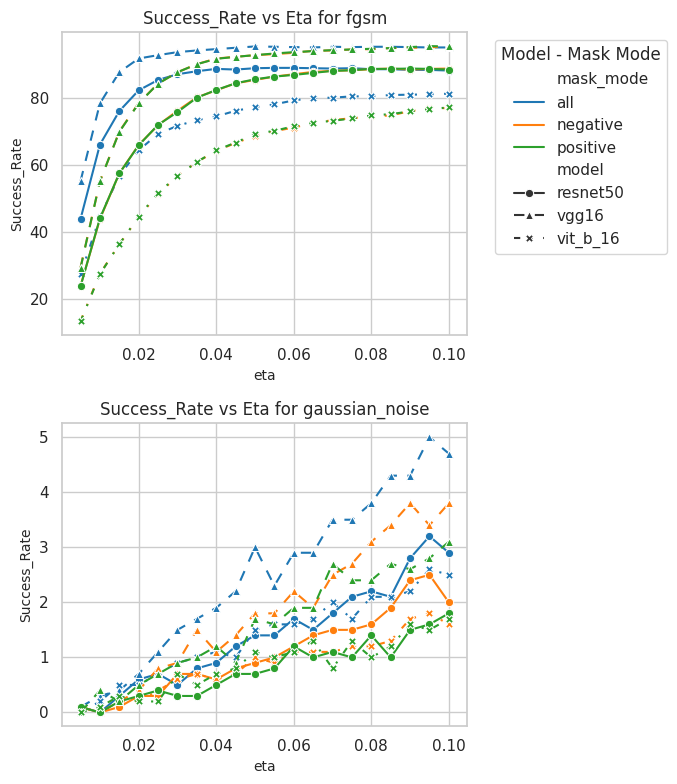

In [49]:
plot_success_rate_vs_eta_temp(data1, algo_list=['fgsm', 'gaussian_noise'], var_list=['success_rate'], output_path=data_root, save_name='success_rate_vs_eta')

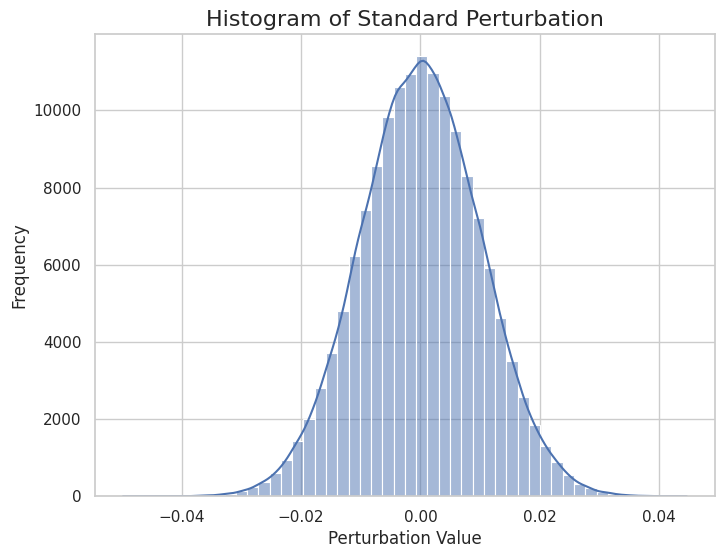

In [46]:
import torch
sigma = 0.01

standard_perturb = torch.randn_like(torch.randn(3, 224, 224)) * sigma
# 画出标准扰动的直方图
plt.figure(figsize=(8, 6))
sns.histplot(standard_perturb.flatten(), bins=50, kde=True)
plt.title('Histogram of Standard Perturbation', fontsize=16)
plt.xlabel('Perturbation Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

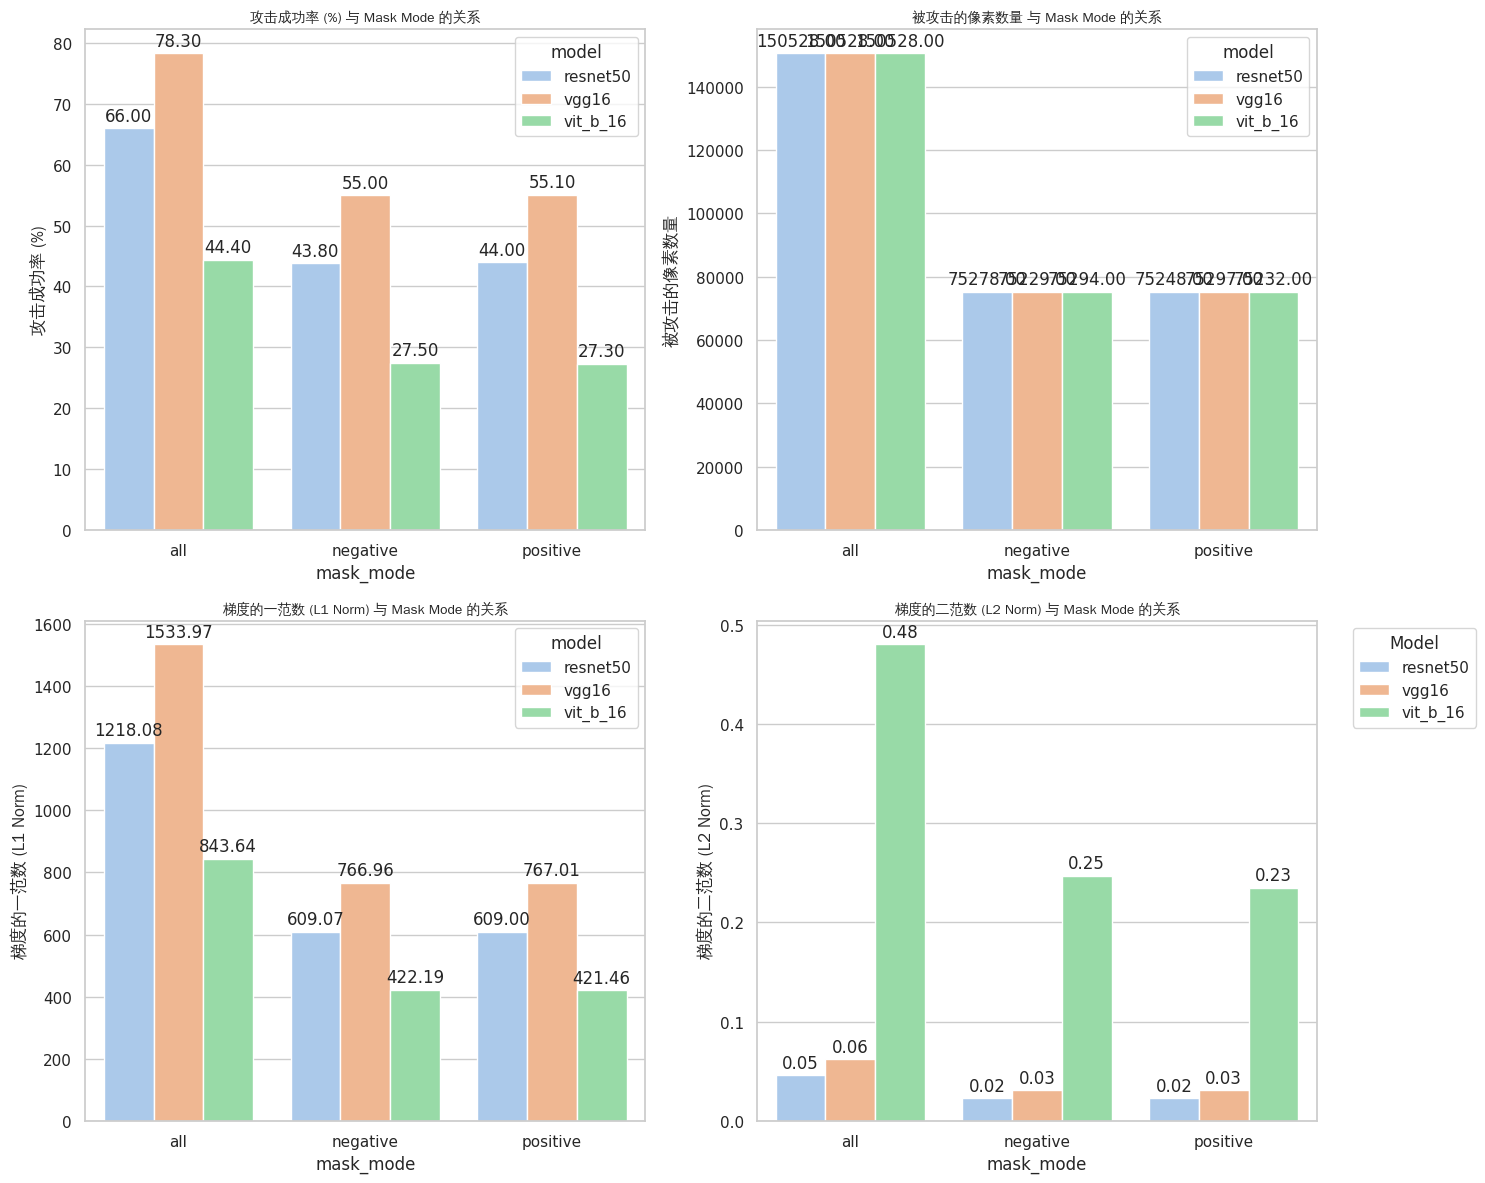

In [54]:
plot_success_rate_vs_norm(data1, 'fgsm', 0.01, output_path=data_root, save_name='success_rate_vs_norm')

/tmp/ipykernel_3286318/112815148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['algo&mask_mode'] = df_model['algo'] + '&' + df_model['mask_mode']
/tmp/ipykernel_3286318/112815148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['algo&mask_mode'] = df_model['algo'] + '&' + df_model['mask_mode']
/tmp/ipykernel_3286318/112815148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


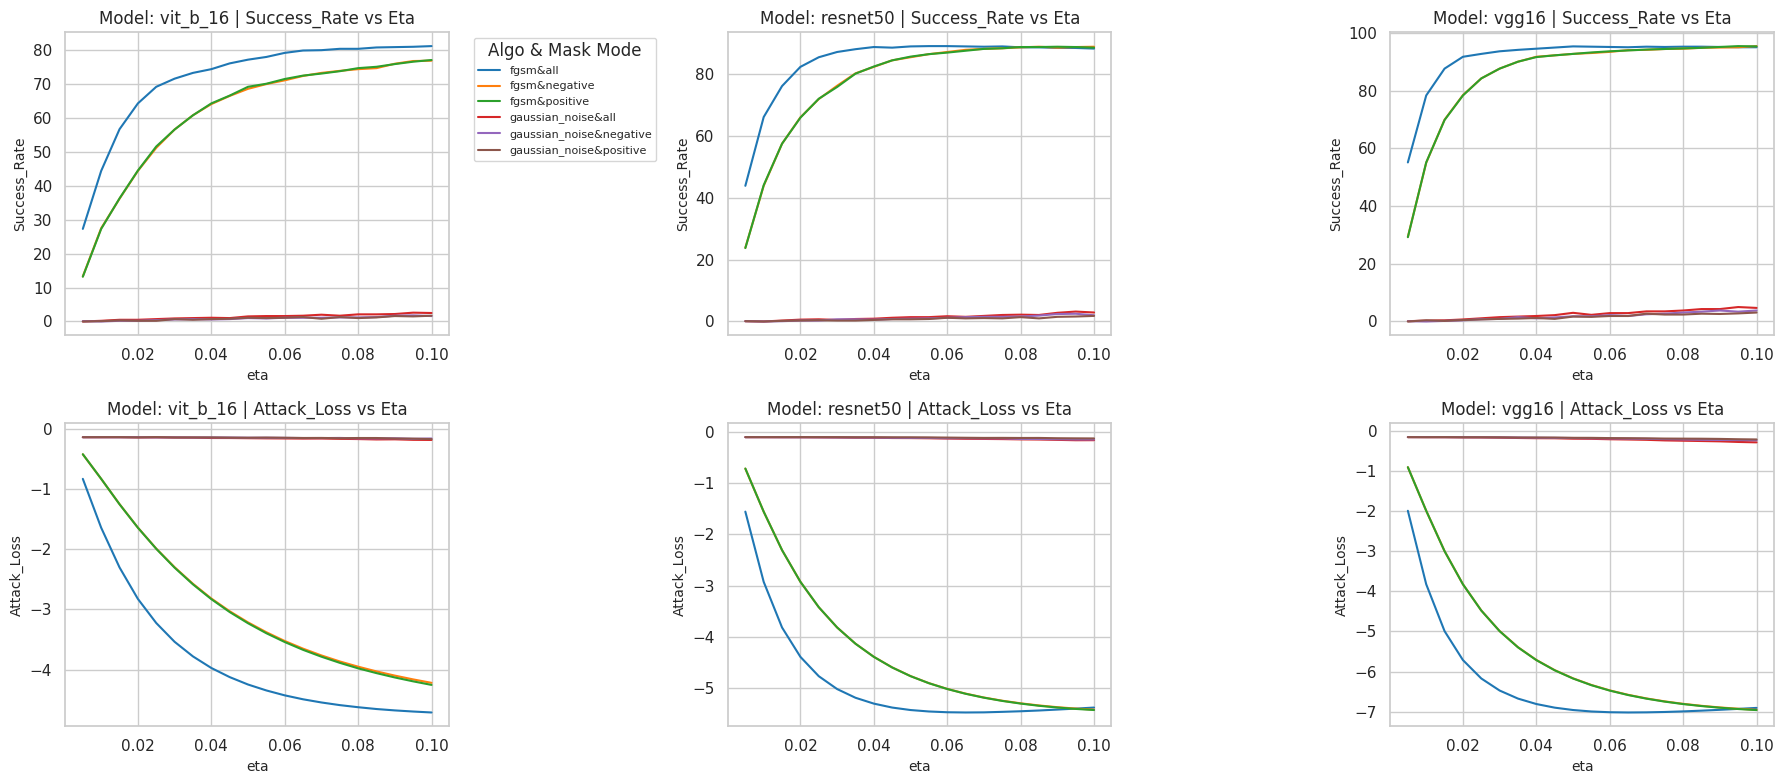

In [34]:
# plot_success_rate_vs_algo(data1, 'vit_b_16')
plot_success_rate_vs_algo(data1, model_list=['vit_b_16', 'resnet50', 'vgg16'], var_list=['success_rate', 'attack_loss'])

# 2. success_rate vs r
- 只考虑mask_mode in ('topr', 'cam_topr', 'randomr', 'cam_lowr', 'lowr')

In [19]:
data2 = data_grouped[data_grouped['mask_mode'].isin(['topr', 'channel_topr', 'cam_topr', 'channel_lowr', 'cam_lowr', 'lowr', 'seed_randomr_lowr', 'seed_randomr'])]
data2.head()

model  algo     mask_mode  parameter   eta  pixel_attacked  l1_norm  \
0  vit_b_16  fgsm  channel_lowr       0.01  0.01            1503   0.0137   
1  vit_b_16  fgsm  channel_lowr       0.02  0.01            3009   0.0357   
2  vit_b_16  fgsm  channel_lowr       0.03  0.01            4515   0.0627   
3  vit_b_16  fgsm  channel_lowr       0.04  0.01            6021   0.0938   
4  vit_b_16  fgsm  channel_lowr       0.05  0.01            7524   0.1285   

    l2_norm  original_loss  attack_loss  success_rate  run_time  \
0  0.000000         -0.065       -0.066           0.0     0.222   
1  0.000000         -0.065       -0.066           0.0     0.211   
2  0.000000         -0.065       -0.066           0.0     0.244   
3  0.000000         -0.065       -0.066           0.0     0.199   
4  0.000001         -0.065       -0.067           0.0     0.206   

   batch_pictures     R     G     B  parameter0  
0              16  0.01  0.01  0.01        0.01  
1              16  0.02  0.02  0.02        0.02  
2              16  0.03  0.03  0.03        0.03  
3              16  0.04  0.04  0.04        0.04  
4              16  0.05  0.05  0.05        0.05

In [20]:
data_grouped.mask_mode.unique()

array(['channel_lowr', 'channel_topr', 'lowr', 'topr'], dtype=object)

In [21]:
data2.mask_mode.unique()

array(['channel_lowr', 'channel_topr', 'lowr', 'topr'], dtype=object)

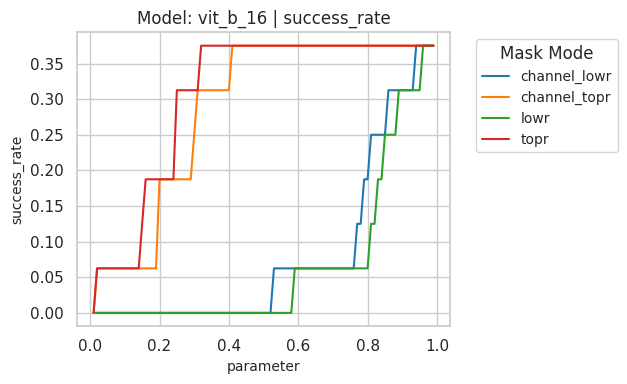

In [22]:
# label_list = ['success_rate', 'l1_norm', 'l2_norm', 'attack_loss']
label_list = ['success_rate']
# plot_success_rate_vs_r(data2, 0.01, 'fgsm', 'parameter', label_list, output_path=data_root, save_name='only_success_rate_vs_parameter', ncols=1, nrows=1)
plot_success_rate_vs_r(data2, 0.01, 'fgsm', 'parameter', label_list, ncols=1, nrows=1, model_list=['vit_b_16'])

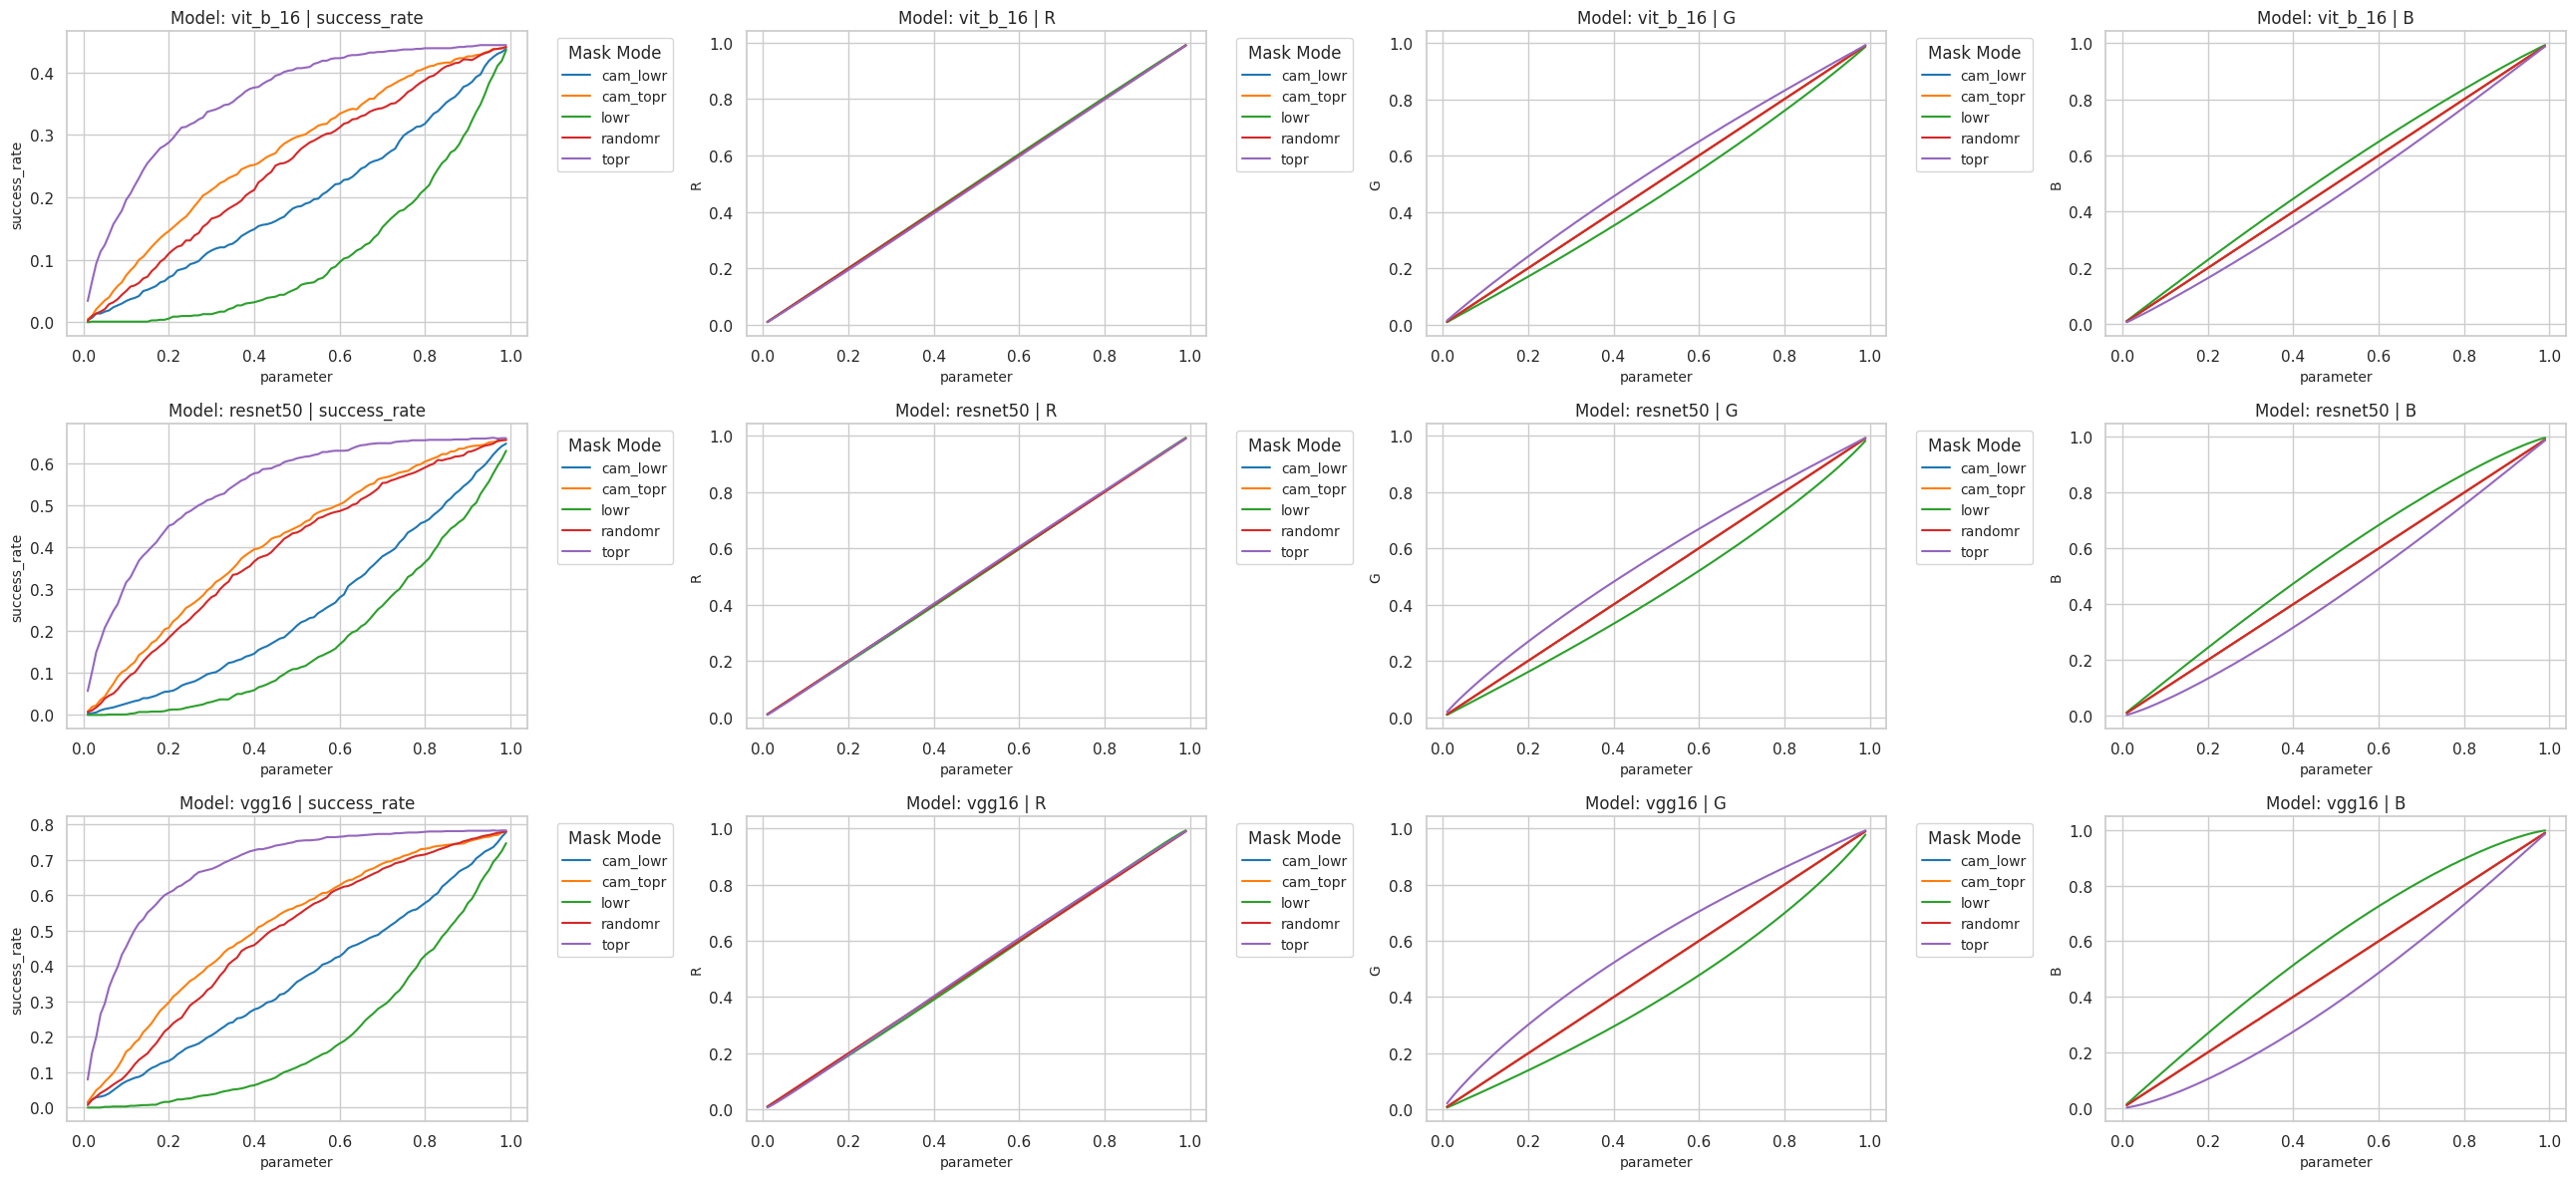

In [10]:
label_list = ['success_rate', 'R', 'G', 'B']
plot_success_rate_vs_r(data2, 0.01, 'fgsm', 'parameter', label_list, output_path=data_root, save_name='success_rate_vs_channel_ratio')

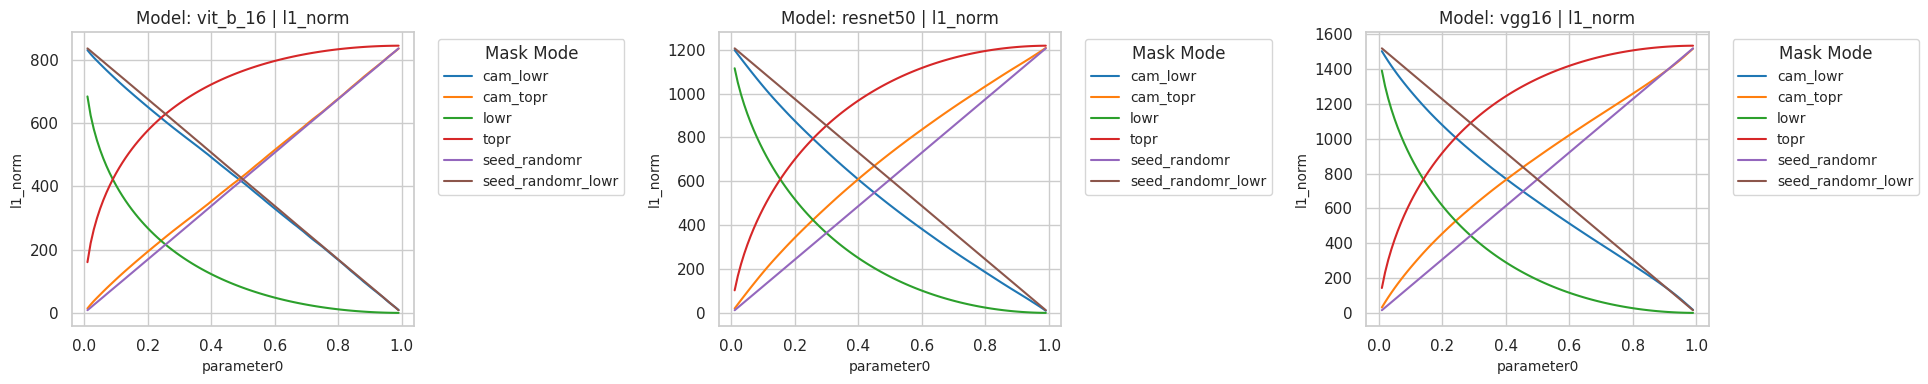

In [51]:
plot_success_rate_vs_r(data2, 0.01, 'fgsm', 'parameter0', ['l1_norm'], output_path=data_root, save_name='only_norm1_vs_r_reverse', ncols=3, nrows=1)

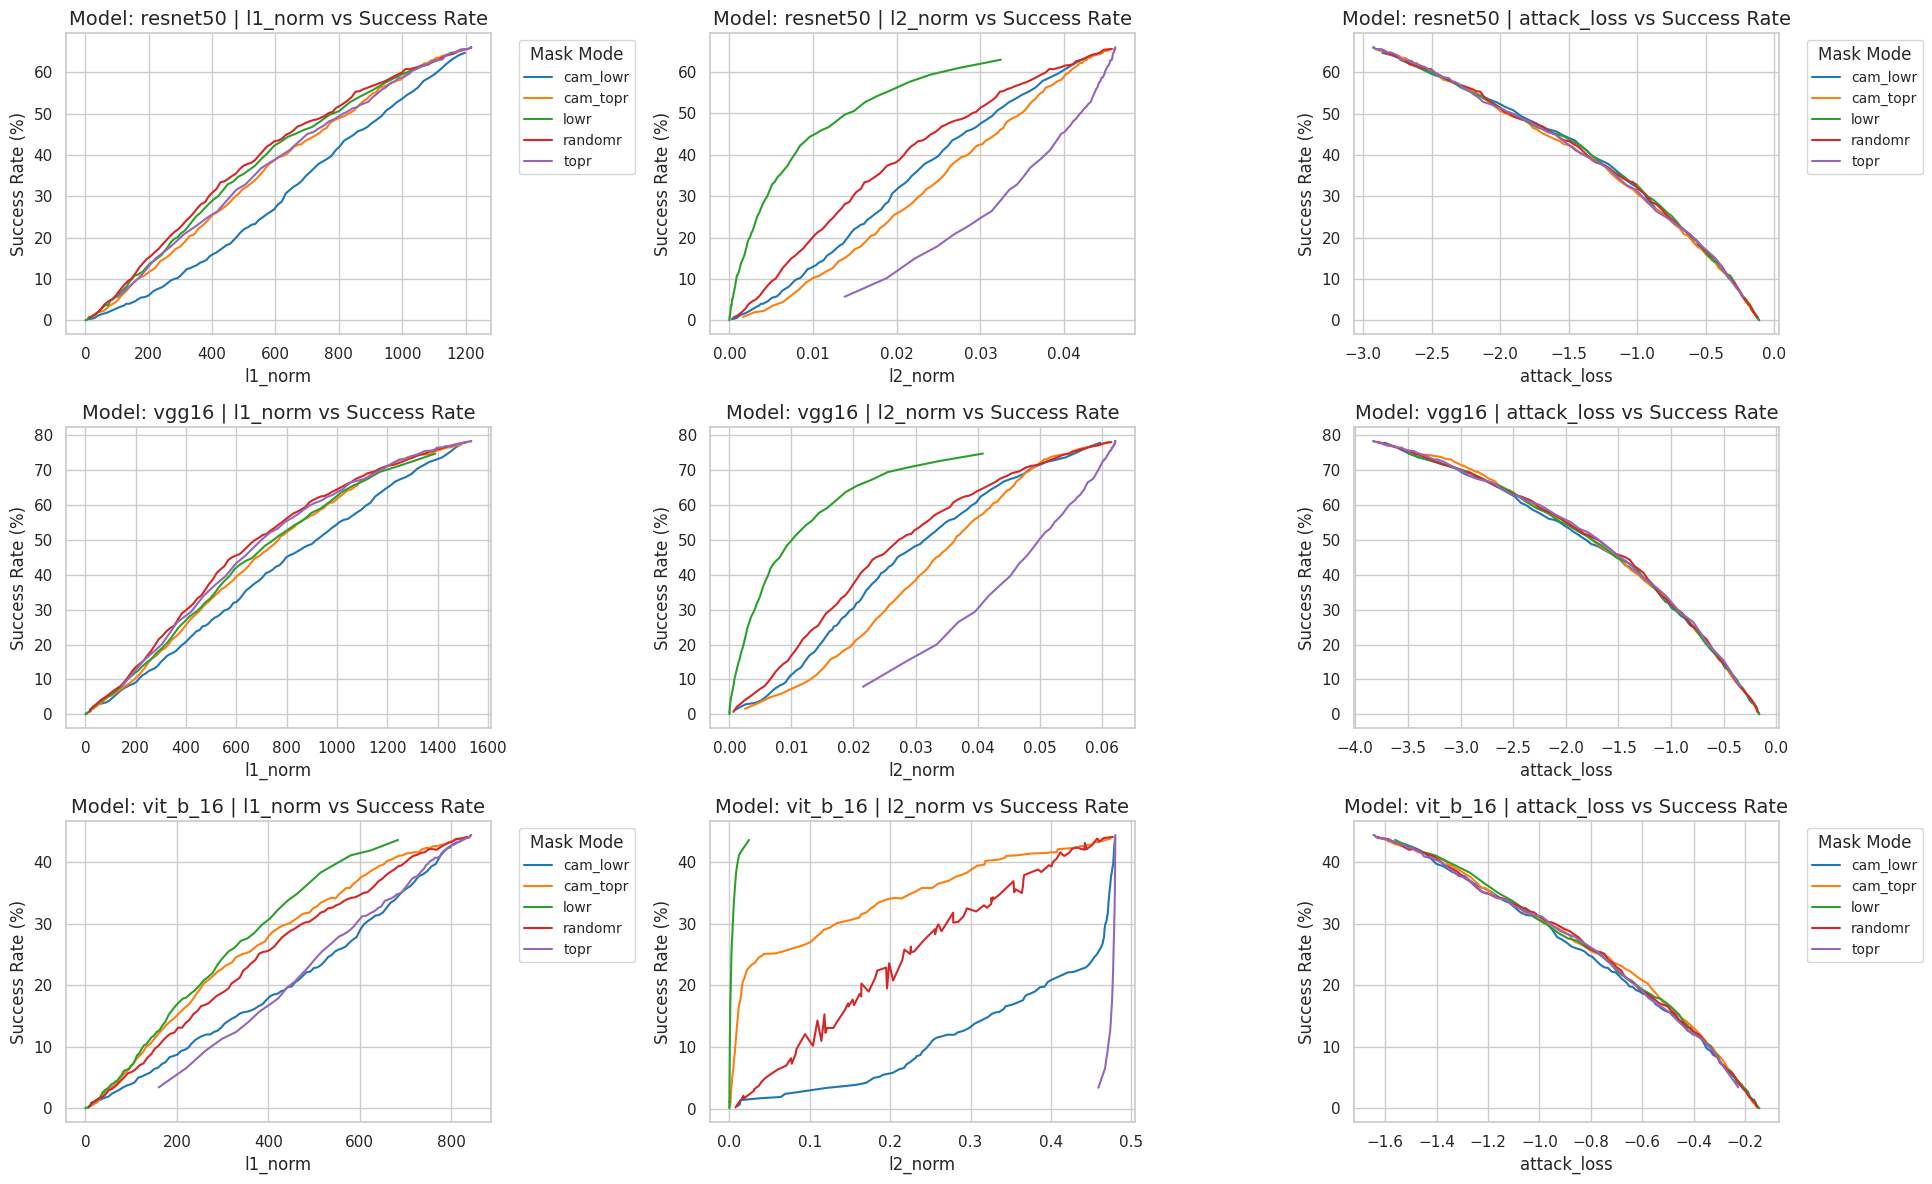

In [96]:
label_list = ['l1_norm', 'l2_norm', 'attack_loss']
plot_metrics_vs_success_rate_lines(data2, 0.01, 'fgsm', label_list, output_path=data_root, save_name='metrics_vs_success_rate_lines')

In [41]:
plot_3d_scatter_plotly(data2, 0.01, 'fgsm', 'l1_norm')

In [42]:
plot_3d_scatter_plotly(data2, 0.01, 'fgsm', 'l2_norm')